# Train an XGBoost for tracing lineage


In [1]:
import bread
import os
import pandas as pd
import numpy as np
path_to_data = os.path.abspath('data')
path_to_colonies = os.path.abspath('data/colonies')


In [2]:
# load the 5 colony ground truth
colonies_gt = pd.DataFrame()
for i in [1, 2, 3, 4, 5]:
    temp_colony = pd.read_csv(os.path.join(
        path_to_colonies, 'colony00{}_lineage.csv'.format(i)))
    temp_colony['colony'] = i
    colonies_gt = colonies_gt.append(temp_colony)
colonies_gt = colonies_gt.reset_index(drop=True)
colonies_gt.rename(columns={'# parent_id': 'parent_GT'}, inplace=True)
colonies_gt


,parent_GT,bud_id,time_index,colony
0,-1,1,0,1
1,-1,2,0,1
2,2,3,4,1
3,1,4,7,1
4,4,5,27,1
...,...,...,...,...
499,22,34,164,5
500,13,35,166,5
501,18,36,169,5
502,3,37,175,5


In [3]:
from bread.algo.lineage import LineageGuesserML
from bread.data import Segmentation, Lineage, SegmentationFile


def extract_features(segmentation_path, args):
    candidate_features = pd.DataFrame(columns=['bud_id', 'candid_id', 'time_id', 'feature1', 'feature2',
                                      'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10'])
    segmentation = SegmentationFile.from_h5(
        segmentation_path).get_segmentation('FOV0')
    guesser = LineageGuesserML(
        segmentation=segmentation,
        nn_threshold=args["nn_threshold"],
        flexible_nn_threshold=args["flexible_nn_threshold"],
        num_frames_refractory=args["num_frames_refractory"],
        num_frames=args["num_frames"],
        bud_distance_max=args["bud_distance_max"]
    )
    bud_ids, time_ids = segmentation.find_buds(
    ).bud_ids, segmentation.find_buds().time_ids
    for i, (bud_id, time_id) in enumerate(zip(bud_ids, time_ids)):
        frame_range = guesser.segmentation.request_frame_range(
            time_id, time_id + guesser.num_frames)
        num_frames_available = guesser.num_frames
        if len(frame_range) < 2:
            # raise NotEnoughFramesException(bud_id, time_id, guesser.num_frames, len(frame_range))
            print("Not enough frames for bud {} at time {}. Only {} frames available.".format(
                bud_id, time_id, len(frame_range)))
        if len(frame_range) < guesser.num_frames:
            num_frames_available = len(frame_range)
            # warnings.warn(NotEnoughFramesWarning(bud_id, time_id, guesser.num_frames, len(frame_range)))
            print("Not enough frames for bud {} at time {}. Only {} frames available.".format(
                bud_id, time_id, len(frame_range)))
        # check the bud still exists !
        for time_id_ in frame_range:
            if bud_id not in guesser.segmentation.cell_ids(time_id_):
                # raise LineageGuesserExpansionSpeed.BudVanishedException(bud_id, time_id_)
                print("Bud {} vanished at time {}".format(bud_id, time_id_))
        selected_times = [i for i in range(
            time_id, time_id + num_frames_available)]
        candidate_parents = guesser._candidate_parents(
            time_id, nearest_neighbours_of=bud_id)
        summary_features = np.zeros(
            (len(candidate_parents), guesser.number_of_features), dtype=np.float64)
        for c_id, candidate in enumerate(candidate_parents):
            try:
                features, _ = guesser._get_ml_features(
                    bud_id, candidate, time_id, selected_times)
                new_row = {'bud_id': bud_id, 'candid_id': candidate, 'time_id': time_id, 'feature1': features[0], 'feature2': features[1], 'feature3': features[2], 'feature4': features[
                    3], 'feature5': features[4], 'feature6': features[5], 'feature7': features[6], 'feature8': features[7], 'feature9': features[8], 'feature10': features[9]}
                candidate_features = candidate_features.append(
                    new_row, ignore_index=True)
            except:
                print("Error for bud {} at time {} with candidate {}".format(
                    bud_id, time_id, candidate))
    return candidate_features


In [ ]:
# extract features for each colony and save them to a csv file. This takes a while. But after this, we only need to load the csv files. every time.
colony_candidate_features = [0, 0, 0, 0, 0, 0]
args = {"nn_threshold": 8.0, "flexible_nn_threshold": True,
        "num_frames_refractory": 0, "num_frames": 4, "bud_distance_max": 10}
for i in [1, 2, 3, 4, 5]:
    print("finding features for colony {}".format(i))
    colony_candidate_features[i] = extract_features(os.path.join(
        path_to_colonies, 'colony00{}_segmentation.h5'.format(i)), args)
    colony_candidate_features[i]['colony'] = i
    # remove rows with time_id = 0
    colony_candidate_features[i] = colony_candidate_features[i][colony_candidate_features[i].time_id != 0]
    # remove rows with bud_id == candid_id (this shouldn't happen in theory)
    colony_candidate_features[i] = colony_candidate_features[i][colony_candidate_features[i].bud_id !=
                                                                colony_candidate_features[i].candid_id]
    # save to csv
    colony_candidate_features[i].to_csv(os.path.join(
        path_to_colonies, 'colony00{}_candidate_features.csv'.format(i)), index=False)


In [7]:
colonies_features = pd.DataFrame()

for i in [1, 2, 3, 4, 5]:
    temp_colony = pd.read_csv(os.path.join(
        path_to_colonies, 'colony00{}_candidate_features.csv'.format(i)))
    colonies_features = colonies_features.append(temp_colony)
colonies_features = colonies_features.reset_index(drop=True)
colonies_features


,bud_id,candid_id,time_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,colony
0,3.0,2.0,4.0,1.000000,2.828427,2.021374,3.756543,3.857483,0.466493,0.049453,0.084671,0.334073,1.144917,1
1,4.0,1.0,7.0,2.236068,2.236068,2.273459,5.357769,6.059181,0.110091,0.026505,1.431141,0.026439,1.525806,1
2,5.0,4.0,27.0,3.000000,3.000000,1.188829,2.604521,2.924109,0.276827,0.084856,1.288088,-0.062777,1.150381,1
3,6.0,1.0,27.0,2.000000,2.236068,1.579244,3.194189,2.956979,1.438397,0.077682,1.175315,0.141315,1.533269,1
4,7.0,1.0,28.0,4.123106,4.472136,1.198652,3.331497,3.895959,0.712322,0.046682,1.465445,-0.233344,0.914119,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,37.0,18.0,175.0,2.000000,2.236068,1.591169,3.207947,2.791266,1.563045,0.050753,1.133295,0.106932,1.514439,5
1047,37.0,26.0,175.0,2.000000,2.000000,2.487022,4.316390,3.097309,1.559877,0.554893,1.323078,-0.039808,1.250352,5
1048,38.0,9.0,178.0,3.000000,3.000000,0.773591,1.949580,2.181251,0.940659,0.366947,0.839169,0.147930,1.135029,5
1049,38.0,14.0,178.0,1.414214,2.828427,1.916193,3.590413,2.653363,1.181054,0.484141,1.471914,-0.068782,1.334349,5


In [9]:
# helper functions for training XGBoost
import numpy as np
import itertools
import xgboost as xgb


def grid_train_xgboost(X_train, y_train, X_test, y_test, max_depths=[2, 3, 4, 5, 10], min_child_weights=[0, 1, 2, 5, 10], early_stopping_rounds=10, num_boost_round=100):
    # This funciton performs grid search through parameters that are influencing the probability of overfitting
    # It returns the values for AUC-ROC for the best model and the values used for training

    best_params = None
    best_acc = 0
    for max_d in max_depths:
        for min_child in min_child_weights:
            params = {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': max_d,
                      'min_child_weight': min_child, 'eval_metric': 'merror'}
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)
            model = xgb.train(params, dtrain, evals=[(dtest, 'test')],
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=False, num_boost_round=num_boost_round)
            preds = model.predict(dtest)
            acc = accuracy_score(y_test, preds)
            print('Accuracy with ', params, 'is ', "%.4f " % (acc))
            if acc > best_acc:
                best_acc = acc
                best_params = params

    print("Best ACC:", best_acc)
    print("Best params:", best_params)
    return best_params


def flatten_3d_array(arr):
    """
    Flattens a 3-dimensional numpy array while keeping the first dimension unchanged
    """
    if arr.ndim == 1:
        arr2 = np.array([arr[i] for i in range(len(arr))])
        arr = np.stack(arr2)
    shape = arr.shape
    new_shape = (shape[0], np.prod(shape[1:]))
    return arr.reshape(new_shape)


def permute_matrix(matrix, row_id):
    """
    Generates all possible permutations of a matrix  rows
    it takes row_index as input, which is a one-hot encoded label for the classification 
    and outputs the one-hot encoded labels of the permutated matrices
    """
    # Get the number of rows in the matrix
    rows = len(matrix)

    # Get all possible permutations of the row indices
    permutations = list(itertools.permutations(range(rows)))

    # Use list comprehension to create a list of all permuted matrices
    permuted_matrices = [np.array([matrix[i] for i in permutation])
                         for permutation in permutations]

    # Use list comprehension to find the index of the specified row in each permuted matrix
    row_indices = [list(permutation).index(row_id)
                   for permutation in permutations]

    return permuted_matrices, row_indices


def generate_all_permutations(data, labels):
    """
    Generates all posible permutations for matrices in data 
    and the corresponding labels
    Labels should be integers
    """

    permuted_matrices_list = []
    permuted_labels_list = []

    for matrix, label in zip(data, labels):
        permuted_matrices, permuted_labels = permute_matrix(matrix, label)
        permuted_matrices_list.extend(permuted_matrices)
        permuted_labels_list.extend(permuted_labels)

    return np.array(permuted_matrices_list), np.array(permuted_labels_list)


def count_classes(y):
    """
    Counts number of zeros and ones in binary classification dataset
    """
    n_zeros = (y == 0).sum()
    n_ones = (y == 1).sum()
    return n_zeros, n_ones


def keep_features(matrices, feature_columns=[0, 1, 2, 3]):
    """
    For a list of bud matrices keep only certain features
    """
    new_matrices = np.zeros(
        (matrices.shape[0], matrices.shape[1], len(feature_columns)))
    for i, fid in enumerate(feature_columns):
        new_matrices[:, :, i] = matrices[:, :, fid]
    return new_matrices


In [15]:
def get_matrix_features(features_all, lineage_gt):
    # Generate np array of feature sets for each bud
    df1 = lineage_gt.copy()
    # remove the rows with parent_GT = -1 (no parent) and the rows with candid_GT = -2 (disappearing buds)
    df1 = df1.loc[df1.parent_GT != -1]
    df1 = df1.loc[df1.parent_GT != -2]
    df2 = features_all.copy()

    features_list = []
    parent_index_list = []
    candidate_list = []
    for bud, colony in df1[['bud_id', 'colony']].values:
        bud_data = df2.loc[(df2['bud_id'] == bud) & (df2['colony'] == colony)]
        candidates = bud_data['candid_id'].to_numpy()
        if candidates.shape[0] < 4:
            candidates = np.pad(
                candidates, ((0, 4 - candidates.shape[0])), mode='constant', constant_values=-3)
        features = bud_data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5',
                             'feature6', 'feature7', 'feature8', 'feature9', 'feature10']].to_numpy()
        if features.shape[0] < 4:
            features = np.pad(features, ((
                0, 4 - features.shape[0]), (0, 0)), mode='constant', constant_values=-1)
        if features.shape[0] > 4:
            sorted_indices = np.argsort(features[:, 0])
            print('more than 4 candidates', bud, colony, candidates, sorted_indices, int(df1.loc[(df1['bud_id'] == bud) & (
                df1['colony'] == colony), 'parent_GT']))
            # slice the top 4 rows
            k = 4
            features = features[sorted_indices[:k]]
            candidates = candidates[sorted_indices[:k]]

        parent = int(df1.loc[(df1['bud_id'] == bud) & (
            df1['colony'] == colony), 'parent_GT'])
        # print(bud, colony, parent)
        # print(candidates)
        if(parent not in candidates):
            print('parent not in candidates', bud, colony, candidates, parent)
            # remove this from the df
            df1.drop(df1.loc[(df1['bud_id'] == bud) & (df1.colony == colony)].index,
                     inplace=True)
            continue
        else:
            parent_index = np.where(candidates == parent)[0][0]

        parent_index_list.append(parent_index)
        features_list.append(features)
        candidate_list.append(candidates)
    df1['features'] = features_list
    df1['candidates'] = candidate_list
    df1['parent_index_in_candidates'] = parent_index_list
    return df1


In [17]:
colonies_matrix_features = get_matrix_features(colonies_features, colonies_gt)


more than 4 candidates 69 3 [12. 19. 21. 42. 67.] [4 0 1 2 3] 12
more than 4 candidates 87 3 [18. 37. 39. 59. 71.] [1 2 0 4 3] 37
parent not in candidates 40 4 [-3. -3. -3. -3.] 24
parent not in candidates 68 4 [ 4.  8. 64. -3.] 39
parent not in candidates 105 4 [-3. -3. -3. -3.] 67


In [32]:
# functions for plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_feature_importance(bst, figsize=(10, 5), title=''):
    """
    Plots the feature importances of an XGBoost model
    """
    plt.figure(figsize=figsize)
    feature_importance = bst.get_score(importance_type='weight')
    feature_importance = {k: v for k, v in sorted(
        feature_importance.items(), key=lambda item: item[1], reverse=True)}
    plt.bar(range(len(feature_importance)), list(
        feature_importance.values()), align='center')
    plt.xticks(range(len(feature_importance)), list(
        feature_importance.keys()), rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Feature importance score')
    plt.title('Feature importance for ' + title)
    plt.show()


def plot_eval_metrics(evals_result, title=''):
    """
    Plot evaluation metrics from an XGBoost model
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    try:
        plt.plot(evals_result['train']['merror'], label='Train')
        plt.plot(evals_result['test']['merror'], label='Validation')

    except:  # For binary classification, the loss is 'error'
        plt.plot(evals_result['train']['error'], label='Train')
        plt.plot(evals_result['test']['error'], label='Validation')

    plt.xlabel('Number of Boosting Rounds')
    plt.ylabel('Error')
    plt.title('Error vs Number of Boosting Rounds for ' + title)
    plt.legend()


def plot_confusion_matrix(y_true, y_pred):
    plt.figure()
    plt.imshow(confusion_matrix(y_true, y_pred), cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def print_matrix(s):
    # Do heading
    print("     ", end="")
    for j in range(len(s[0])):
        print("%5d " % j, end="")
    print()
    print("     ", end="")
    for j in range(len(s[0])):
        print("------", end="")
    print()
    # Matrix contents
    for i in range(len(s)):
        print("%3d |" % (i), end="")  # Row nums
        for j in range(len(s[0])):
            print("%.3f " % (s[i][j]), end="")
        print()


In [33]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def train_xgboost_matrix(matrix_features_df, augment=True):
    X = matrix_features_df['features'].to_numpy()
    y = matrix_features_df['parent_index_in_candidates'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True)
    if augment:
        X_train, y_train = generate_all_permutations(X_train, y_train)
    X_train = flatten_3d_array(X_train)
    X_test = flatten_3d_array(X_test)

    # Train the default XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {'objective': 'multi:softmax',
              'num_class': 4, 'eval_metric': 'merror'}
    model = xgb.train(params, dtrain, num_boost_round=100)
    # Make predictions and evaluate the model
    dtest = xgb.DMatrix(X_test, label=y_test)
    preds = model.predict(dtest)
    preds = np.round(preds)
    print("Accuracy of the default model:", "%.4f " %
          accuracy_score(y_test, preds))

    # Searching for optimal tree depth to prevent overfitting
    # early stopping rounds specidies the number of epochs after which the training will stop if there is no improvement in accuracy
    best_params = grid_train_xgboost(
        X_train, y_train, X_test, y_test, early_stopping_rounds=10, num_boost_round=100)

    print('best_params', best_params)

    # Make predictions with best_params
    print('=======================  best model  ========================')
    evals_result = {}
    bst = xgb.train(best_params, dtrain, num_boost_round=200, early_stopping_rounds=20, evals=[
        (dtest, 'test'), (dtrain, 'train')], verbose_eval=False, evals_result=evals_result)
    # Make predictions and evaluate the best model
    preds = bst.predict(dtest)
    preds = np.round(preds)
    print("Accuracy of the best model:", "%.4f " %
          accuracy_score(y_test, preds))
    plot_eval_metrics(evals_result, title='best model')

    # train model with custom parameters
    print('=======================  custom model  ========================')
    custom_params = {'objective': 'multi:softmax', 'num_class': 4,
                     'max_depth': 10, 'min_child_weight': 5, 'eval_metric': 'merror'}
    evals_result = {}
    model = xgb.train(custom_params, dtrain, num_boost_round=200, early_stopping_rounds=20, evals=[
        (dtest, 'test'), (dtrain, 'train')], verbose_eval=False, evals_result=evals_result)
    # Make predictions and evaluate the custom model
    preds = model.predict(dtest)
    preds = np.round(preds)
    print("Accuracy of the custom model:", "%.4f " %
          accuracy_score(y_test, preds))
    plot_eval_metrics(evals_result, title='custom model')
    plot_feature_importance(model, title='custom model')
    return model, bst


Accuracy of the default model: 0.8454 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 0, 'eval_metric': 'merror'} is  0.8247 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 1, 'eval_metric': 'merror'} is  0.8247 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 2, 'eval_metric': 'merror'} is  0.8247 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 5, 'eval_metric': 'merror'} is  0.8247 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 10, 'eval_metric': 'merror'} is  0.8247 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 3, 'min_child_weight': 0, 'eval_metric': 'merror'} is  0.7938 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 3, 'min_child_weight': 1, 'eval_metric': 'merror'} is  0.

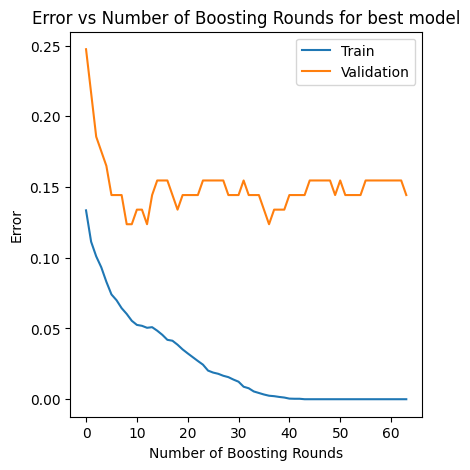

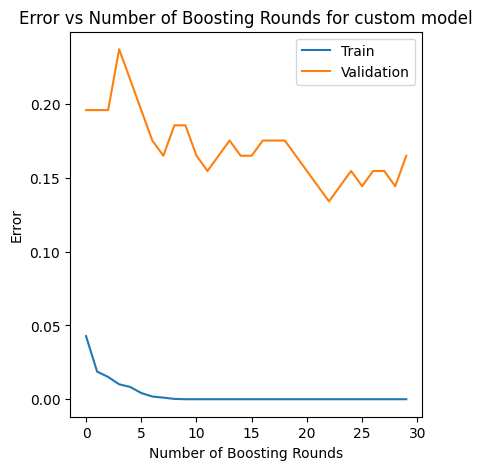

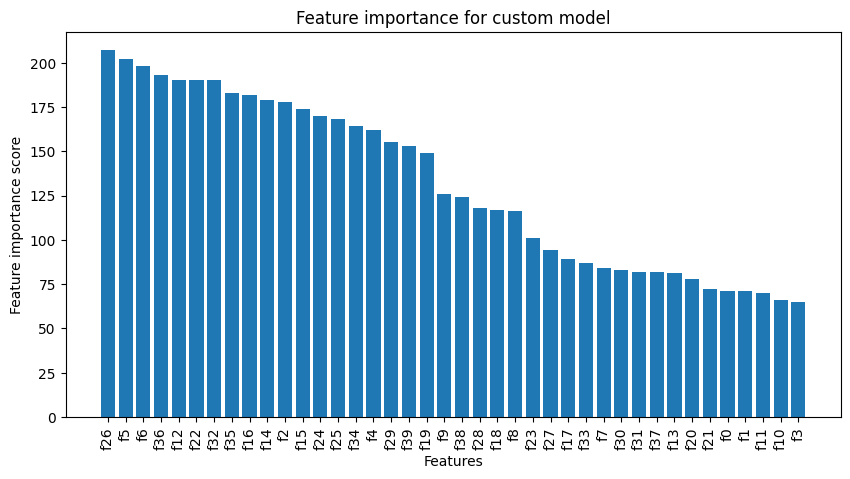

In [34]:
model, bst = train_xgboost_matrix(colonies_matrix_features, augment=True, )


In [35]:
# save the model with custom parameters
best_model_path = 'best_model.json'
custom_model_path = 'custom_model.json'
model.save_model(custom_model_path)
bst.save_model(best_model_path)


## Test on unseen images

we test on a colony that haven't been seen by the train set at all.


In [36]:
colony0_segmentation_path = '/home/farzaneh/Documents/Bread/bread/src/bread/tests/data/V2022_09_19_HTB2_mCh_MYO1-GFP_50_ms/FOV0_segmentation_T0_to_T146_trimmed.h5'
colony0_lineage_GT_path = '/home/farzaneh/Documents/Bread/bread/src/bread/tests/data/V2022_09_19_HTB2_mCh_MYO1-GFP_50_ms/FOV0_lineage_T0_to_T146.csv'

colony0_lineage_gt = pd.read_csv(colony0_lineage_GT_path)
colony0_lineage_gt.rename(columns={'parent_id': 'parent_GT'}, inplace=True)


In [38]:

args = {"nn_threshold": 8.0, "flexible_nn_threshold": True,
        "num_frames_refractory": 0, "num_frames": 4, "bud_distance_max": 10.0}
colony0_features = extract_features(colony0_segmentation_path, args)
colony0_features['colony'] = [0 for i in range(len(colony0_features))]
colony0_lineage_gt = pd.read_csv(colony0_lineage_GT_path).rename(
    columns={'parent_id': 'parent_GT'})
colony0_lineage_gt['colony'] = [0 for i in range(len(colony0_lineage_gt))]
colony0_matrix_features = get_matrix_features(
    colony0_features, colony0_lineage_gt)
X = colony0_matrix_features['features'].to_numpy()
y = colony0_matrix_features['parent_index_in_candidates'].to_numpy()

X = flatten_3d_array(X)
dtest = xgb.DMatrix(X, label=y)
saved_model = xgb.Booster()
saved_model.load_model(best_model_path)
saved_model_preds = saved_model.predict(dtest)
saved_model_preds = np.round(saved_model_preds)
print("Accuracy of the best saved model:", "%.4f " %
      accuracy_score(y, saved_model_preds))
print(np.sum(saved_model_preds != y))


/home/farzaneh/Documents/Bread/bread/src/bread/data/_data.py:589: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


Bud 44 vanished at time 75
Bud 44 vanished at time 76
Bud 44 vanished at time 77
Error for bud 44 at time 74 with candidate 18
Not enough frames for bud 344 at time 144. Only 3 frames available.
Not enough frames for bud 345 at time 144. Only 3 frames available.
Not enough frames for bud 346 at time 144. Only 3 frames available.
Not enough frames for bud 347 at time 144. Only 3 frames available.
Not enough frames for bud 348 at time 144. Only 3 frames available.
Not enough frames for bud 349 at time 144. Only 3 frames available.
Not enough frames for bud 350 at time 144. Only 3 frames available.


/home/farzaneh/Documents/Bread/bread/src/bread/data/_data.py:589: MultipleContoursWarning: OpenCV returned multiple contours, 4 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


Not enough frames for bud 351 at time 144. Only 3 frames available.
Not enough frames for bud 352 at time 144. Only 3 frames available.
Not enough frames for bud 353 at time 145. Only 2 frames available.
Not enough frames for bud 354 at time 145. Only 2 frames available.
Not enough frames for bud 355 at time 145. Only 2 frames available.
Not enough frames for bud 356 at time 145. Only 2 frames available.
Not enough frames for bud 357 at time 145. Only 2 frames available.
Not enough frames for bud 358 at time 146. Only 1 frames available.
Not enough frames for bud 358 at time 146. Only 1 frames available.


/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/

Not enough frames for bud 359 at time 146. Only 1 frames available.
Not enough frames for bud 359 at time 146. Only 1 frames available.
Not enough frames for bud 360 at time 146. Only 1 frames available.
Not enough frames for bud 360 at time 146. Only 1 frames available.
Not enough frames for bud 361 at time 146. Only 1 frames available.
Not enough frames for bud 361 at time 146. Only 1 frames available.


/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/

Not enough frames for bud 362 at time 146. Only 1 frames available.
Not enough frames for bud 362 at time 146. Only 1 frames available.
Not enough frames for bud 363 at time 146. Only 1 frames available.
Not enough frames for bud 363 at time 146. Only 1 frames available.
Not enough frames for bud 364 at time 146. Only 1 frames available.
Not enough frames for bud 364 at time 146. Only 1 frames available.


/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/

Not enough frames for bud 365 at time 146. Only 1 frames available.
Not enough frames for bud 365 at time 146. Only 1 frames available.
Not enough frames for bud 366 at time 146. Only 1 frames available.
Not enough frames for bud 366 at time 146. Only 1 frames available.
Not enough frames for bud 367 at time 146. Only 1 frames available.
Not enough frames for bud 367 at time 146. Only 1 frames available.


/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/farzaneh/anaconda3/envs/lpbs_bread/lib/python3.7/site-packages/ipykernel_launcher.py:47: RankWarning: Polyfit may be poorly conditioned
/home/

Not enough frames for bud 368 at time 146. Only 1 frames available.
Not enough frames for bud 368 at time 146. Only 1 frames available.
parent not in candidates 163 0 [102. 134.  -3.  -3.] 54
more than 4 candidates 168 0 [  1.  33.  77. 154. 159.] [1 2 4 3 0] 1
parent not in candidates 168 0 [ 33.  77. 159. 154.] 1
parent not in candidates 184 0 [ 15.  25. 120.  -3.] 104
parent not in candidates 207 0 [  7.  13. 140.  -3.] 81
parent not in candidates 233 0 [ 25.  62. 120.  -3.] 106
parent not in candidates 243 0 [ 25. 233.  -3.  -3.] 15
parent not in candidates 253 0 [115.  -3.  -3.  -3.] 56
more than 4 candidates 262 0 [ 48.  80. 137. 183. 244.] [2 1 4 3 0] 137
parent not in candidates 280 0 [ 27. 105. 212.  -3.] 11
parent not in candidates 321 0 [ 53.  92. 107.  -3.] 96
parent not in candidates 323 0 [57. 58. -3. -3.] 100
more than 4 candidates 343 0 [159. 182. 270. 290. 305.] [1 0 2 3 4] 182
parent not in candidates 353 0 [ 96. 202. 227.  -3.] 90
parent not in candidates 362 0 [207.

In [42]:
# Check if the accuracy is better when we only use the first 100 cells.
trim_data = colony0_matrix_features.loc[colony0_matrix_features['time_index'] < 50]
X = trim_data['features'].to_numpy()
y = trim_data['parent_index_in_candidates'].to_numpy()

X = flatten_3d_array(X)
dtest = xgb.DMatrix(X, label=y)
saved_model_preds = saved_model.predict(dtest)
saved_model_preds = np.round(saved_model_preds)
print("Accuracy of the saved model for first frames:", "%.4f " %
      accuracy_score(y, saved_model_preds))
print(np.sum(saved_model_preds != y))


Accuracy of the saved model for first frames: 0.8667 
2


the accuracy for 100 first frames is better than for all frames (146) (between 3 to 6 percents difference). The accuracy for 50 first frame is also around the same and it's close to validation prediction in model. we can conclude that the prediction get harder when image is much more crowded.


## Add FOV0 buds to colonies and train on all


In [62]:
pd.set_option("display.max_rows", 10, "display.max_columns", 20)


In [43]:
all_matrix_features = colony0_matrix_features.append(
    colonies_matrix_features).reset_index(drop=True)
all_matrix_features


,parent_GT,bud_id,time_index,colony,features,candidates,parent_index_in_candidates
0,1,5,18,0,"[[2.23606797749979, 2.8284271247461903, 2.3462...","[1.0, -3.0, -3.0, -3.0]",0
1,3,6,18,0,"[[1.0, 3.0, 3.1110787609318864, 6.903387316722...","[3.0, -3.0, -3.0, -3.0]",0
2,2,7,20,0,"[[1.0, 3.0, 0.9423480319763353, 2.690179222401...","[2.0, 3.0, 4.0, -3.0]",0
3,4,8,22,0,"[[1.0, 2.0, 2.1075425855503496, 4.077661350281...","[4.0, -3.0, -3.0, -3.0]",0
4,1,9,32,0,"[[2.0, 2.0, 1.758930190470974, 3.7266767166400...","[1.0, 5.0, -3.0, -3.0]",0
...,...,...,...,...,...,...,...
828,22,34,164,5,"[[2.0, 3.0, 1.180091771838302, 2.4426740817652...","[22.0, 25.0, -3.0, -3.0]",0
829,13,35,166,5,"[[2.0, 3.0, 0.8067932399673025, 1.901524565203...","[13.0, -3.0, -3.0, -3.0]",0
830,18,36,169,5,"[[6.324555320336759, 12.083045973594572, 0.209...","[2.0, 9.0, 18.0, -3.0]",2
831,3,37,175,5,"[[2.23606797749979, 2.23606797749979, 1.508481...","[3.0, 18.0, 26.0, -3.0]",0


Accuracy of the default model: 0.8503 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 0, 'eval_metric': 'merror'} is  0.8024 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 1, 'eval_metric': 'merror'} is  0.8024 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 2, 'eval_metric': 'merror'} is  0.8024 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 5, 'eval_metric': 'merror'} is  0.8084 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 2, 'min_child_weight': 10, 'eval_metric': 'merror'} is  0.8144 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 3, 'min_child_weight': 0, 'eval_metric': 'merror'} is  0.8084 
Accuracy with  {'objective': 'multi:softmax', 'num_class': 4, 'max_depth': 3, 'min_child_weight': 1, 'eval_metric': 'merror'} is  0.

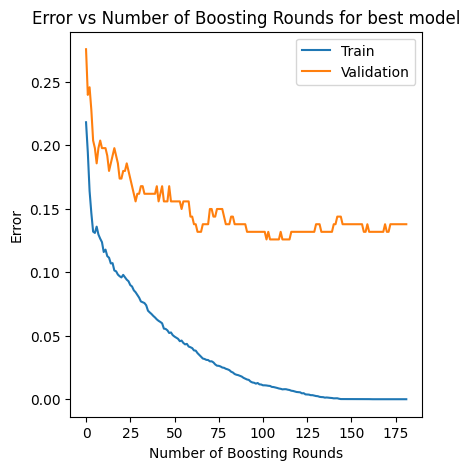

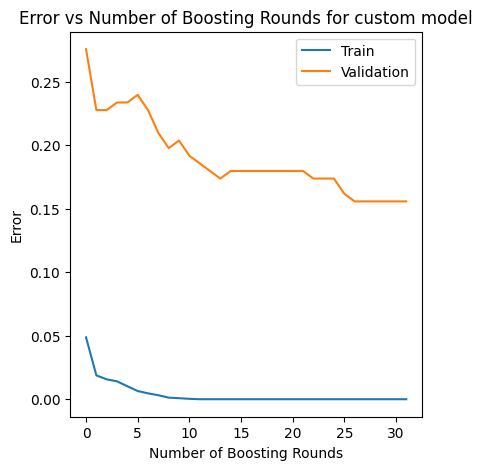

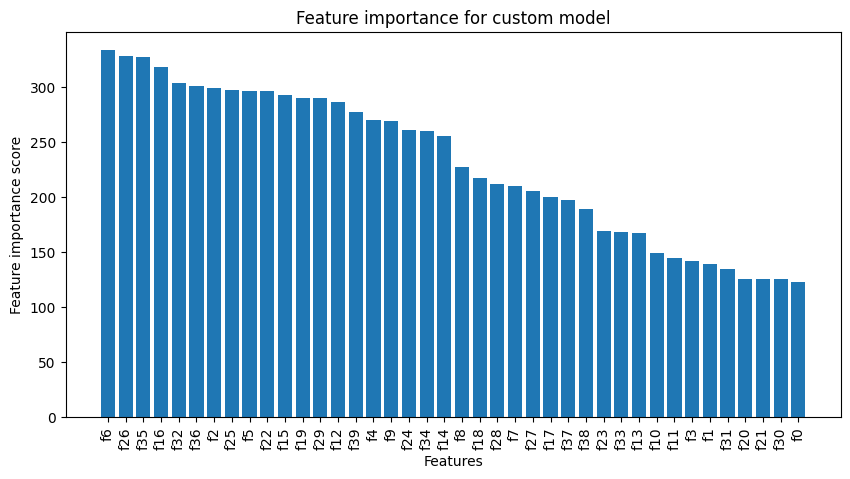

In [48]:
# train and test on the combined data

model, bst = train_xgboost_matrix(all_matrix_features, augment=True, )
model_path = 'model_all_colonies.json'
model.save_model(model_path)


## train on 4 colonies and test on 2

colony 4 and 5 have chosen for test because 4 was a problematic colony and 5 was a normal one.


In [83]:
train_matrix_features = all_matrix_features[~ (
    (all_matrix_features['colony'] == 4) | (matrix_feature_df['colony'] == 5))]
test_matrix_features = all_matrix_features[(
    all_matrix_features['colony'] == 4) | (matrix_feature_df['colony'] == 5)]
X_train = train_matrix_features['features'].to_numpy()
X_test = test_matrix_features['features'].to_numpy()
y_train = train_matrix_features['parent_index_in_candidates'].to_numpy()
y_test = test_matrix_features['parent_index_in_candidates'].to_numpy()
# Train the default XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
params = {'objective': 'multi:softmax',
          'num_class': 4, 'eval_metric': 'merror'}
bst = xgb.train(params, dtrain, num_boost_round=100)
# Make predictions and evaluate the model
dtest = xgb.DMatrix(X_test, label=y_test)
preds = bst.predict(dtest)
preds = np.round(preds)
print("Accuracy of the default model:", "%.4f " %

      accuracy_score(y_test, preds))


ValueError: Please reshape the input data into 2-dimensional matrix.